In [1]:
import torch
from PIL import Image
import torch.nn.functional as F
from torchvision.models.resnet import resnet18
import torchvision.transforms as transforms
from functools import partial
import numpy as np
import cv2

In [2]:
image_size = (224, 224)

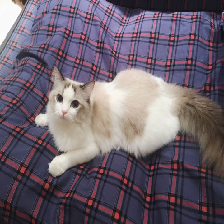

In [3]:
image = Image.open('./data/test.jpg').convert('RGB').resize(image_size)
image

In [4]:
model = resnet18(pretrained=True)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

In [6]:
input_image = preprocess(image).unsqueeze(0)
features = [None]
grads = [None]
def hook(module, inputs, outputs, features):
    features[0] = inputs
def back_hook(module, inputs, outputs, features):
    features[0] = outputs


In [7]:
model.layer4[1].conv2.register_forward_hook(partial(hook, features=features))
model.layer4[1].conv2.register_backward_hook(partial(back_hook, features=grads))

# model.avgpool.register_forward_hook(partial(hook, features=features))
# model.avgpool.register_backward_hook(partial(back_hook, features=grads))
out = model(input_image)
_, pred_class = torch.max(out, 1)
out[0, pred_class].backward()

In [8]:
print('Feature shape ', features[0][0].shape)
print('Grad shape', grads[0][0].shape)

Feature shape  torch.Size([1, 512, 7, 7])
Grad shape torch.Size([1, 512, 7, 7])


In [9]:
weights = torch.sum(grads[0][0], dim=(2, 3))
print(weights.shape)

torch.Size([1, 512])


In [10]:
grad_cam = F.relu(torch.sum((features[0][0].T * weights.T).T, dim=1).squeeze())

In [11]:
grad_cam = grad_cam.detach().numpy()
grad_cam = grad_cam - np.min(grad_cam)
grad_cam_image = grad_cam / np.max(grad_cam)
grad_cam_image = np.uint8(grad_cam_image * 255)

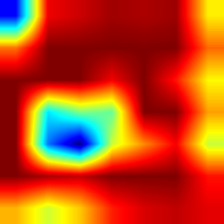

In [12]:
heatmap = cv2.applyColorMap(cv2.resize(grad_cam_image,image_size), cv2.COLORMAP_JET)
Image.fromarray(heatmap)

In [13]:
img = np.array(image)
out = img * 0.7 + heatmap * 0.3

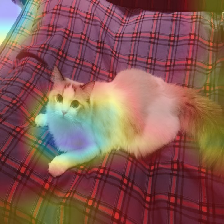

In [14]:
Image.fromarray(out.astype(np.uint8))